# Proceso de distincion de ventas x materiales

### Librerias

In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import os 

import const
from utils import mask_float
from random import randint

from sklearn import model_selection
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn.metrics import mean_absolute_error

### Funciones

In [144]:
def remove_outlier(df_in, col_name):
    
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

### Preprocesamiento

In [20]:
header_names = ["oficinas", "clientes", "agentes", "segmentos", "ventas", "materiales"]

converters = {
    "oficinas": str,
    "clientes": str,
    "agentes": str,
    "segmentos": str,
    "ventas": mask_float,
    "materiales": mask_float
}

data = pd.read_csv(os.path.join(const.ROOT_DIR, "files/bases/base.csv"), 
    sep = ";", 
    skiprows = 1,
    usecols = [0, 1, 2, 4, 5, 6], 
    names = header_names, 
    converters = converters
    )

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15455 entries, 0 to 15454
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   oficinas    15455 non-null  object 
 1   clientes    15455 non-null  object 
 2   agentes     15455 non-null  object 
 3   segmentos   15455 non-null  object 
 4   ventas      15455 non-null  float64
 5   materiales  15455 non-null  float64
dtypes: float64(2), object(4)
memory usage: 724.6+ KB


In [21]:
#replace agentes for ("Directa" or "Indirecta")
mask_indirecta = data["agentes"].str.contains("#")
data.loc[mask_indirecta, "agentes"] = "Indirecta"
data.loc[~mask_indirecta, "agentes"] = "Directa"

#delete 0'ros inside "Ventas" or "materiales"
mask_zero = (data["ventas"] <= 0) & (data["materiales"] == 0)
data.drop(data[mask_zero].index, inplace=True)
data.head()

,oficinas,clientes,agentes,segmentos,ventas,materiales
0,R Bogota Norte,10005806,Indirecta,Mayorista Snackero,3769314.0,45.0
1,R Bogota Norte,10005806,Indirecta,Mayorista Snackero,6746115.0,40.0
2,R Bogota Norte,10005806,Indirecta,Mayorista Snackero,9655944.0,59.0
3,R Bogota Norte,10005806,Indirecta,Mayorista Snackero,5245732.0,32.0
4,R Bogota Norte,10005806,Indirecta,Mayorista Snackero,10195569.0,56.0


In [57]:
#group all
data_grouped = data.groupby(["oficinas", "clientes", "agentes", "segmentos"], as_index=False)[["ventas", "materiales"]].sum()
data_grouped.head()

,oficinas,clientes,agentes,segmentos,ventas,materiales
0,R Altillano,10037570,Indirecta,MY Com Rapi/Transf,2053142.0,29.0
1,R Altillano,10051413,Indirecta,Mayorista Snackero,33116428.0,382.0
2,R Altillano,10091442,Indirecta,Mayorista Mixto,60321598.0,131.0
3,R Altillano,10091466,Indirecta,Mayorista Snackero,223166779.0,720.0
4,R Altillano,10091469,Indirecta,Mayorista Mixto,49201280.0,223.0


In [56]:
data_grouped.shape

(74, 5)

### Analisis

In [24]:
data_grouped.describe()

,ventas,materiales
count,2.871000e+03,2871.000000
mean,1.090676e+08,193.479624
std,2.589604e+08,162.746037
min,1.465000e+03,1.000000
25%,1.204994e+07,79.000000
50%,3.809022e+07,155.000000
75%,1.004377e+08,263.000000
max,4.226465e+09,1460.000000


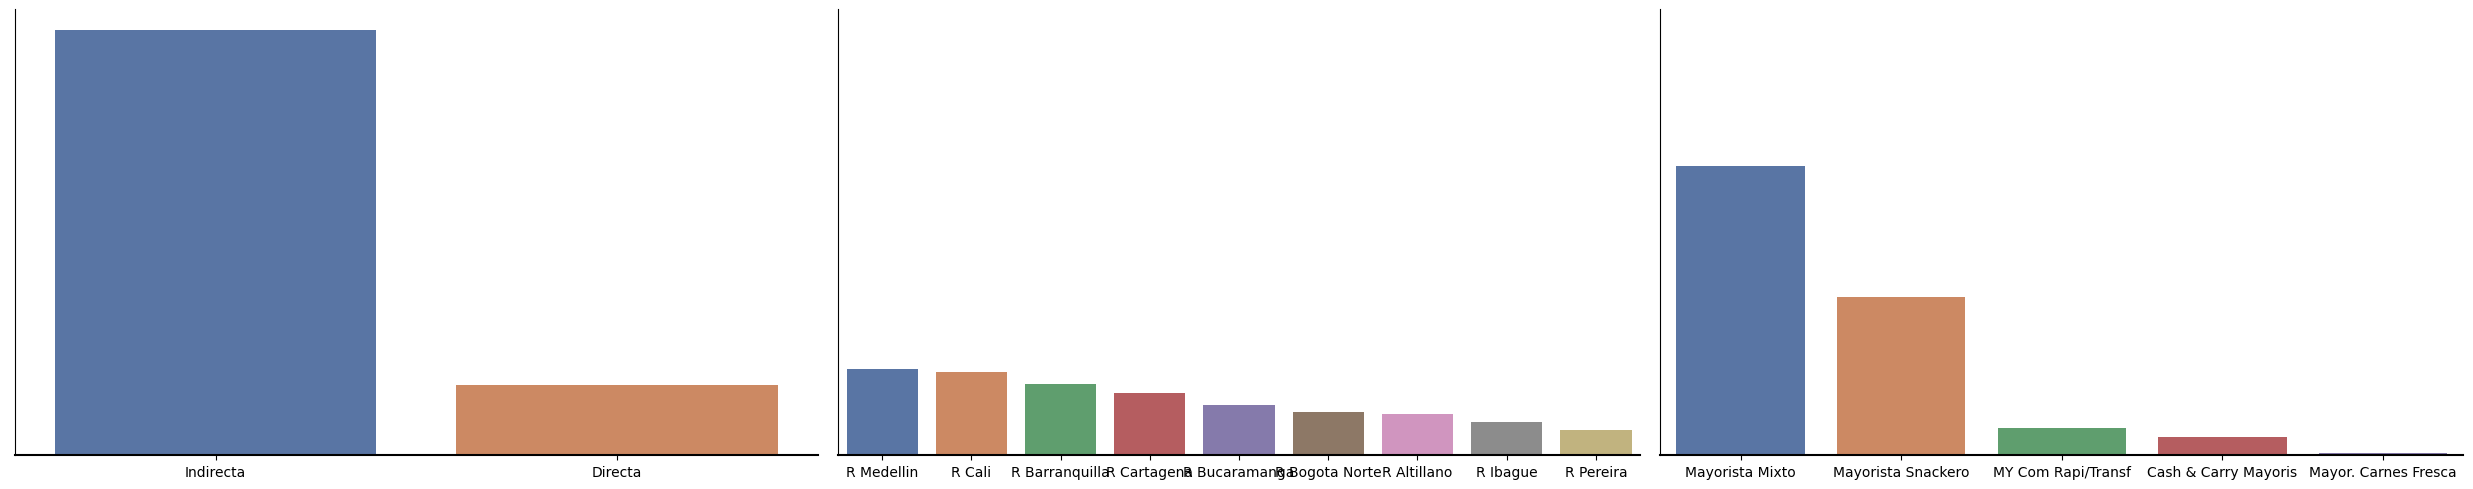

In [49]:
f, axs = plt.subplots(1, 3, figsize=(25, 5), sharey=True)

for idx, group in enumerate(["agentes", "oficinas", "segmentos"]):
    uniques = data[group].value_counts()
    sns.barplot(x=list(uniques.index), y=list(uniques.values), palette="deep", ax=axs[idx])
    axs[idx].axhline(0, color="k", clip_on=False)

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

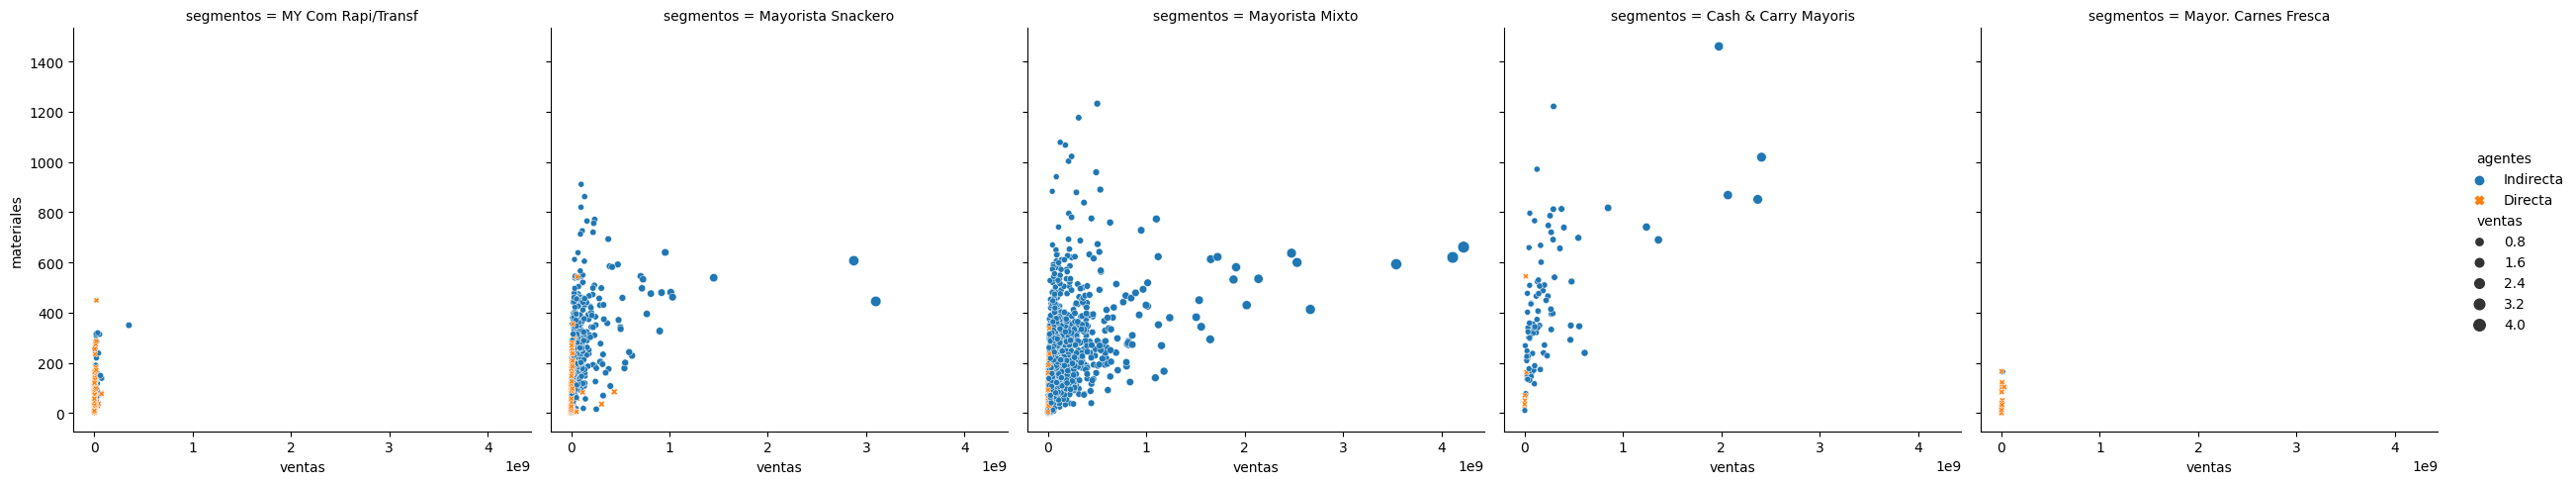

In [26]:
# Create a visualization
sns.relplot(
    data=data_grouped,
    x="ventas", y="ventas", col="segmentos",
    hue="agentes", style="agentes", size="ventas",
)

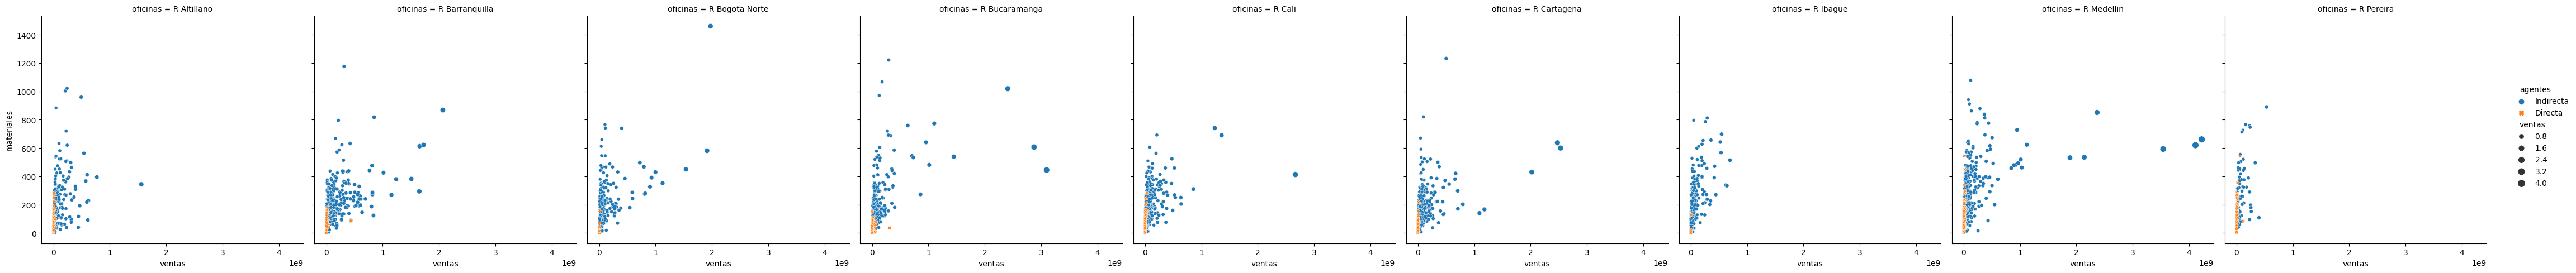

In [28]:
sns.relplot(
    data=data_grouped,
    x="ventas", y="materiales", col="oficinas",
    hue="agentes", style="agentes", size="ventas",
)

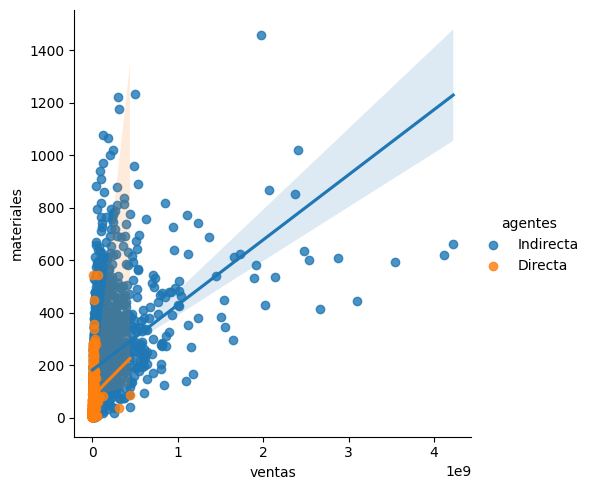

In [30]:
sns.lmplot(data=data_grouped, x="ventas", y="materiales", hue="agentes")

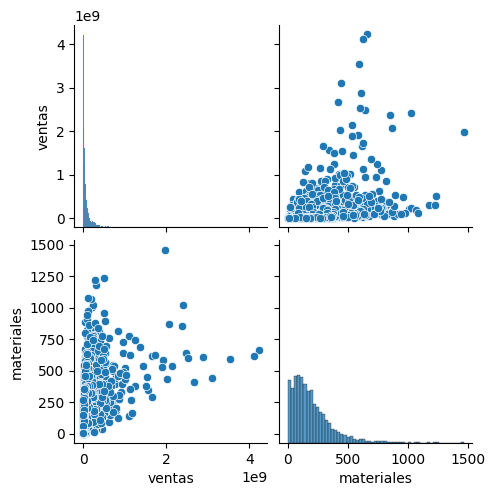

In [83]:
sns.pairplot(data_grouped[["ventas", "materiales"]])

### Transformación

In [58]:
#shuffle data
data_grouped.sample(frac=1).reset_index(drop=True)

#delete column "clientes" = id
data_grouped.drop(['clientes'], axis = 1, inplace = True) 

data_grouped.head()

,oficinas,agentes,segmentos,ventas,materiales
0,R Altillano,Indirecta,MY Com Rapi/Transf,2053142.0,29.0
1,R Altillano,Indirecta,Mayorista Snackero,33116428.0,382.0
2,R Altillano,Indirecta,Mayorista Mixto,60321598.0,131.0
3,R Altillano,Indirecta,Mayorista Snackero,223166779.0,720.0
4,R Altillano,Indirecta,Mayorista Mixto,49201280.0,223.0


In [65]:
#tranform categorical data
encoders = {
    "oficinas": LabelEncoder(),
    "segmentos": LabelEncoder(),
    "agentes": LabelBinarizer(),
}

for key in encoders.keys():
    data_grouped[key] = encoders[key].fit_transform(data_grouped[key].values)


# feature-scaling - StandardScaler
scaler = StandardScaler()
scaler.fit(data_grouped.values)
transform_data = pd.DataFrame(scaler.transform(data_grouped.values), index=data_grouped.index, columns=data_grouped.columns)
transform_data.head()

,oficinas,agentes,segmentos,ventas,materiales
0,-1.625023,0.423149,-2.262991,-0.413318,-1.010828
1,-1.625023,0.423149,0.968299,-0.293344,1.158573
2,-1.625023,0.423149,-0.108798,-0.188270,-0.383976
3,-1.625023,0.423149,0.968299,0.440681,3.235791
4,-1.625023,0.423149,-0.108798,-0.231220,0.181421


### Entrenamiento y validación

<AxesSubplot:>

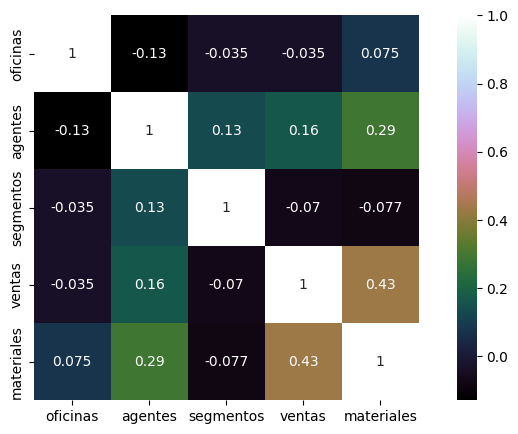

In [157]:
corr_mat = transform_data.corr(method='pearson')
plt.figure(figsize=(10,5))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')

In [268]:
x_temp = transform_data.values[:, :-1]
y = transform_data.values[:, -1]

#transform to polynomial function
func_poly = PolynomialFeatures(degree=2, include_bias=False)
x = func_poly.fit_transform(x_temp)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)

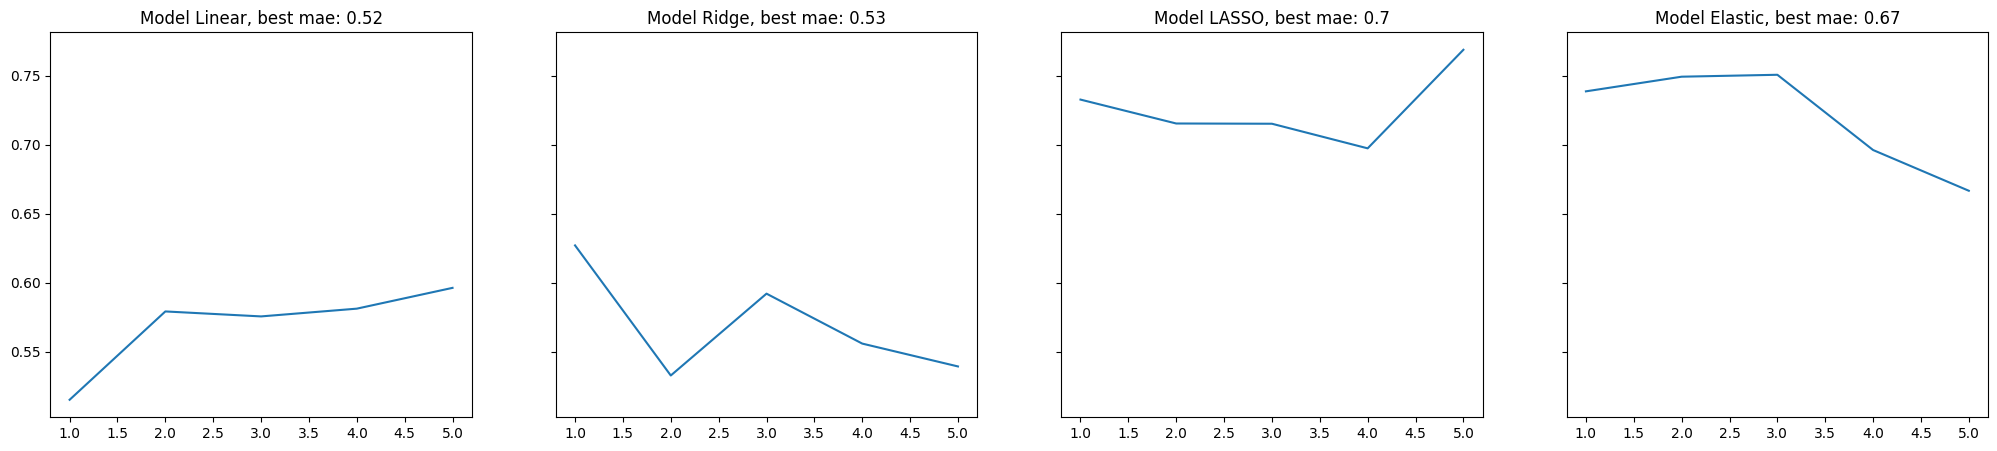

In [269]:
from sklearn.feature_selection import RFE

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "LASSO": Lasso(),
    "Elastic": ElasticNet()
}

maes = {
    key: None for key in models.keys()
}

best_folds = {
    **maes
}

f, axs = plt.subplots(1, len(models), sharey='all', figsize=(25,5))

for idx, (key, model) in enumerate(models.items()):

    kfolds = model_selection.KFold(n_splits=5, random_state = randint(1, 10), shuffle=True).split(x_train, y_train) #iterable (only use train sub group)

    best_fold = None
    best_mae = 1
    _maes = []

    for idx_train, idx_test in kfolds:
        
        model.fit(x_train[idx_train], y_train[idx_train])
        mae = mean_absolute_error(y_train[idx_test], model.predict(x_train[idx_test]))
        _maes.append(mae)

        if np.abs(mae) < np.abs(best_mae):
            best_mae = mae
            best_fold = (idx_train, idx_test) #save only index
    
    #save the best sub fold use for train and the mean MAE result
    best_folds[key] = best_fold
    maes[key] = np.abs(_maes).mean()

    #plot actual mean MAE
    axs[idx].plot(list(range(1, len(_maes) + 1)), np.abs(_maes))
    axs[idx].set_title(f"Model {key}, best mae: {round(best_mae, 2)}")

In [251]:
#train models with the best subfold
for key in models.keys():
    idx_train, _ = best_folds[key]
    models[key].fit(x_train[idx_train], y_train[idx_train])

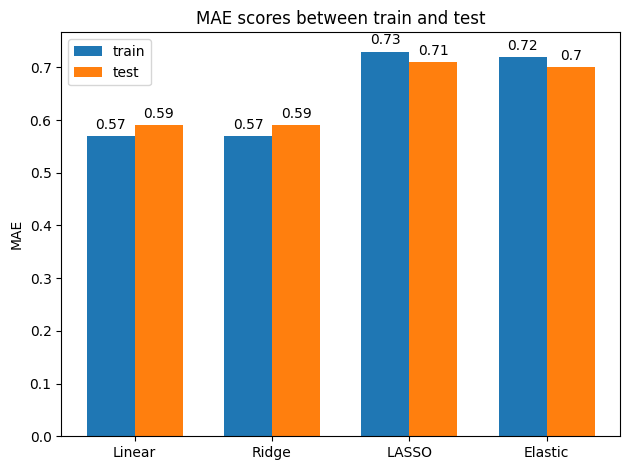

In [270]:
fig, axs = plt.subplots()

x_label = np.arange(len(maes))
width = 0.35  # the width of the bars

maes_results = []

for key_model in maes.keys():
    maes_results.append([
        round(maes[key_model], 2),
        round(mean_absolute_error(y_test, models[key_model].predict(x_test)), 2)
    ])

axs.set_ylabel('MAE')
axs.set_title('MAE scores between train and test')
axs.set_xticks(x_label, maes.keys())

rects1 = axs.bar(x_label - width/2, np.array(maes_results)[:, 0].tolist(), width, label='train')
rects2 = axs.bar(x_label + width/2, np.array(maes_results)[:, 1].tolist(), width, label='test')
axs.bar_label(rects1, padding=3)
axs.bar_label(rects2, padding=3)

axs.legend()
fig.tight_layout()

plt.show()

MAE: 0.5940061991567461


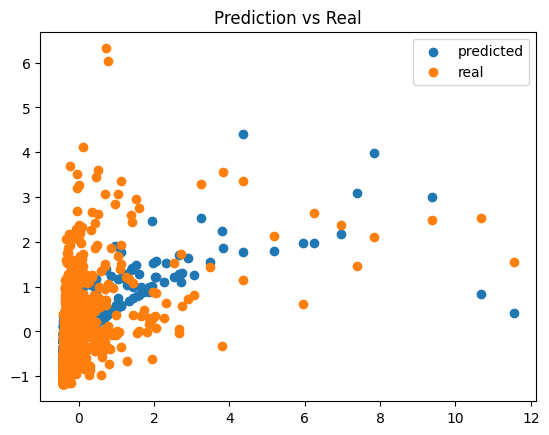

In [271]:
from sklearn.metrics import accuracy_score

prediction = models['Linear'].predict(x_test)

print(f"MAE: {mean_absolute_error(prediction, y_test)}")

plt.title('Prediction vs Real')
plt.scatter(x_test[:, 3], prediction, label='predicted')
plt.scatter(x_test[:, 3], y_test, label='real')
plt.legend()
plt.show()

In [275]:
precision = np.mean(np.abs(y_test - prediction))
precision

0.5940061991567461

In [272]:
model.coef_

array([ 0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.01422941, -0.        ,
        0.        ,  0.        , -0.        ,  0.0161017 ])

PCA y Kfold

>1 -0.726 (0.033)
>2 -0.727 (0.043)


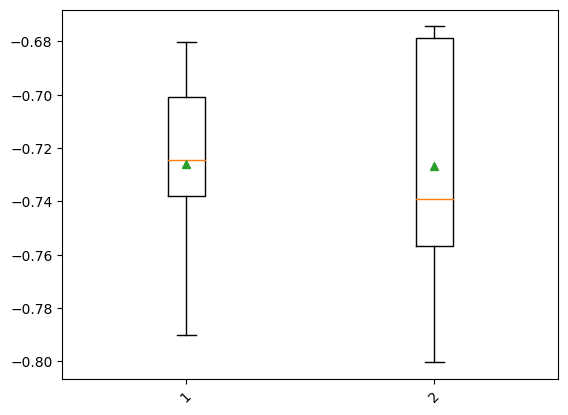

In [205]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


def get_models():
	models = dict()
	for i in range(1, transform_data.shape[1]-2):
		steps = [('pca', PCA(n_components = i)), ('m', LinearRegression())]
		models[str(i)] = Pipeline(steps=steps)
	return models

def evaluate_model(model, x, y):
	cv = model_selection.KFold(n_splits=10, shuffle=True)
	scores = model_selection.cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs= -1)
	return scores

x, y = transform_data.values[:, :-2], transform_data.values[:, -1]
models = get_models()
results, names = [], []

for name, model in models.items():
	scores = evaluate_model(model, x, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

In [132]:
np.arange(1, len(maes)+1)

array([1, 2, 3, 4])

In [127]:
x_label

[0, 1, 2, 3]

In [126]:
x_label - len(x_label)/2

TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [125]:
len(x_label)/2

2.0

In [124]:
width

0.35

In [122]:
np.array(real_results)[:, 0].tolist()

[0.6237493299721538,
 0.6222663789636129,
 0.7375121806642081,
 0.7379251577592434]

4